In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mediapipe as mp
import cv2
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import os
from tensorflow.keras.models import load_model

In [3]:
# Expressions labels
expressions = ["anger", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
train_data_dir = 'Dataset/train/'
test_data_dir = 'Dataset/test/'

In [4]:
# Moving window for smoothing predictions
PREDICTION_WINDOW = deque(maxlen=5)

In [5]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False, max_num_faces=5, min_detection_confidence=0.5
)

In [6]:
def build_model():
    """Build the CNN model."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(48, 48, 1)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(7, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    print(model.summary())
    return model
build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

In [7]:
def train_model(model, train_dir, test_dir, epochs=50):
    """Train the model with given data."""
    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=30,
        shear_range=0.3,
        zoom_range=0.3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode="grayscale",
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        shuffle = True
    )
    validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        color_mode="grayscale",
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        shuffle = True
    )

    num_train_imgs = 0
    for root, dirs, files in os.walk(train_data_dir):
        num_train_imgs += len(files)
    num_test_imgs = 0
    for root, dirs, files in os.walk(test_data_dir):
        num_test_imgs += len(files)
    
    print(num_train_imgs)
    print(num_test_imgs)

    history = model.fit(
        train_generator,
        steps_per_epoch=num_train_imgs // 32,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_test_imgs // 32,
    
    )

    model.save("model_CNN.h5")

    return history

In [8]:
def preprocess_face(face_img):
    """Preprocess a face image for prediction."""
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized / 255.0
    return normalized.reshape(1, 48, 48, 1)

In [9]:
def detect_expression(frame, model):
    """Detect facial expression in a video frame."""
    height, width, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            x_min = y_min = float("inf")
            x_max = y_max = float("-inf")

            for landmark in face_landmarks.landmark:
                x, y = int(landmark.x * width), int(landmark.y * height)
                x_min = min(x_min, x)
                x_max = max(x_max, x)
                y_min = min(y_min, y)
                y_max = max(y_max, y)

            padding = 20
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(width, x_max + padding)
            y_max = min(height, y_max + padding)

            face = frame[y_min:y_max, x_min:x_max]
            if face.size == 0:
                continue

            processed_face = preprocess_face(face)
            prediction = model.predict(processed_face)[0]
            PREDICTION_WINDOW.append(prediction)

            avg_prediction = np.mean(PREDICTION_WINDOW, axis=0)
            expression = expressions[np.argmax(avg_prediction)]
            confidence = float(avg_prediction.max())

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(
                frame,
                f"{expression} ({confidence:.2f})",
                (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
                (0, 255, 0),
                2,
            )

    return frame

In [10]:
def run_realtime(model):
    """Run real-time facial expression detection."""
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        processed_frame = detect_expression(frame, model)

        cv2.imshow("Facial Expression Detection", processed_frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

In [11]:
def evaluate_model(model, test_dir, history):
    """Evaluate the model and visualize the results."""
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=False,
    )

    # Get predictions and calculate metrics
    predictions = model.predict(test_generator)
    true_labels = test_generator.classes
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(
        true_labels, predicted_labels, target_names=expressions
    )
    accuracy = np.sum(true_labels == predicted_labels) / len(true_labels)

    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=expressions,
        yticklabels=expressions,
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot Accuracy and Loss over Epochs
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [12]:
def main():
    # Build the model
    model = build_model()

    # Train the model (optional, you can load a pretrained model)
    train = input("Do you want to train the model? (y/n): ")
    if train.lower() == 'y':
        history = train_model(model, train_data_dir, test_data_dir, epochs=60)
    else:
        # Load pre-trained model (if available)
        if os.path.exists("model_CNN.h5"):
            model = load_model("model_CNN.h5")
            print("Model loaded successfully.")
        else:
            print("No pre-trained model found. You should train the model first.")
            return

    # Evaluate the model on the test set
    evaluate = input("Do you want to evaluate the model? (y/n): ")
    if evaluate.lower() == 'y':
        evaluate_model(model, test_data_dir, history)

    # Run real-time facial expression detection
    run_realtime_choice = input("Do you want to run real-time facial expression detection? (y/n): ")
    if run_realtime_choice.lower() == 'y':
        run_realtime(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                 

c:\Users\merie\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 7177 images belonging to 7 classes.
225/225 [==============================] - 13s 50ms/step
Overall Accuracy: 58.98%

Classification Report:
              precision    recall  f1-score   support

       anger       0.47      0.53      0.50       958
     disgust       0.62      0.09      0.16       111
        fear       0.47      0.17      0.25      1024
       happy       0.81      0.84      0.82      1774
         sad       0.49      0.66      0.56      1233
    surprise       0.47      0.48      0.47      1247
     neutral       0.70      0.77      0.73       830

    accuracy                           0.59      7177
   macro avg       0.58      0.51      0.50      7177
weighted avg       0.59      0.59      0.57      7177



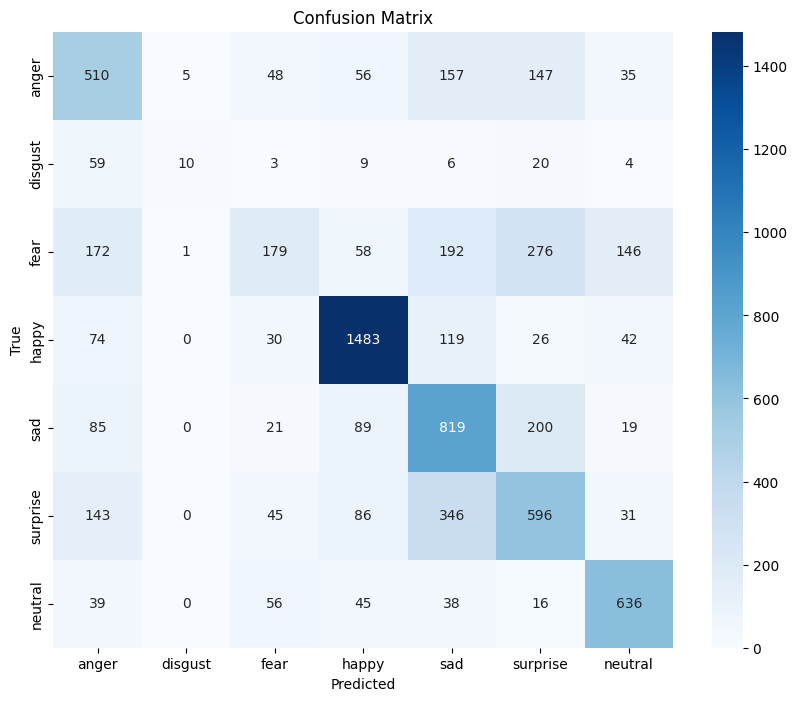

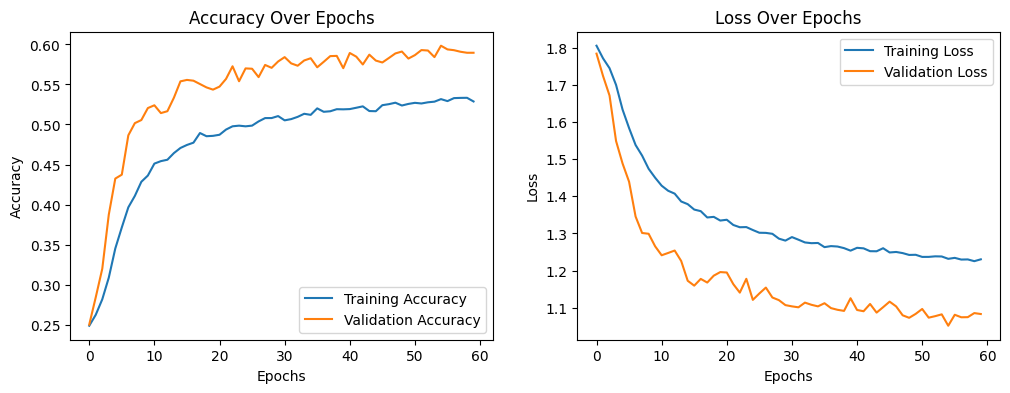

1/1 [==============================] - 0s 21ms/step


In [13]:
if __name__ == "__main__":
    main()